In [1]:
COLAB = False

In [2]:
import sys
sys.path.append("/media/paniquex/samsung_2tb/IDAO_2021_oski/src")


from collections import defaultdict
import os
import random

import numpy as np
import pandas as pd
import yaml
import shutil
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch import nn
import torch



from transformers import get_linear_schedule_with_warmup

from datasets import SimpleDataset
from models import Wrapper
from pipeline_utils import evaluate_test
from models import ENCODER_PARAMS


# os.chdir("/media/paniquex/samsung_2tb/")

In [3]:
PATH_TO_CFG = "/media/paniquex/samsung_2tb/IDAO_2021_oski/experiments/resnest50d_4s2x40d_1e-4_joint_BCE_L1_with_private_augmented/config.yaml"
with open(PATH_TO_CFG, "r") as file:
    config = yaml.load(file)

DATA_ROOT = config["general"]["data_root"]

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

fix_seed(config["general"]["seed"])
device_ids = [str(id) for id in config["general"]["device_ids"]]
ids = ",".join(device_ids)
DEVICE = torch.device(f"cuda:{ids}")

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
import albumentations
from albumentations import *
from albumentations.pytorch import ToTensorV2

transforms_test = albumentations.Compose([
    CenterCrop(*config["preprocessing"]["center_crop_size"]),
    Resize(*config["preprocessing"]["img_size"]),
    Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225],
     ),
    ToTensorV2()
])

In [6]:
# test = pd.read_csv(os.path.join(DATA_ROOT, "test.csv"))
if COLAB:
    path = "IDAO_2021_oski/data/track_1/idao_dataset" # directory with public_test and private_test directories
else:
    path = "/media/paniquex/samsung_2tb/IDAO_2021_oski/data/track_1/idao_dataset" # directory with public_test and private_test directories
    
file_names_public = [x for x in os.listdir(os.path.join(path, "public_test")) if ".png" in x] #+ os.listdir(os.path.join(path, "private_test"))
test_csv = pd.DataFrame({"file_path": file_names_public, "type": "public"})
file_names_private = [x for x in os.listdir(os.path.join(path, "private_test")) if ".png" in x]#+ os.listdir(os.path.join(path, "private_test"))
test_csv = test_csv.append(pd.DataFrame({"file_path": file_names_private, "type": "private"})).reset_index()

test_csv.loc[test_csv["type"] == "public", "file_path"] = str(os.path.join(path, "public_test")) + "/" + test_csv["file_path"]
test_csv.loc[test_csv["type"] == "private", "file_path"] = str(os.path.join(path, "private_test")) + "/" + test_csv["file_path"]

test = test_csv

test_dataset = SimpleDataset(df=test, mode="test", transform=transforms_test)

test_dataloader = DataLoader(test_dataset, **config["testing"]["dataloader"])

In [7]:
if config["general"]["task_type"] == "regression":
    config["general"]["classes_num"] = 1

In [8]:
model_name = config["general"]["model_name"]
model = ENCODER_PARAMS[model_name]["init_op"]()


if config["general"]["task_type"] == "regression":
    config["general"]["classes_num"] = 1
elif config["general"]["task_type"] == "joint":
    config["general"]["classes_num"] = 2

if config["training"]["loss"] == "AAM":
    criterion_aam = AngularPenaltySMLoss
else:
    criterion_aam = None
model = Wrapper(model, feat_module=None, classes_num=config["general"]["classes_num"],
                    model_name=model_name,
                spec_augmenter=None, 
                mixup_module=None,
                task_type=config["general"]["task_type"],
                activation_func=config["training"]["activation_func"],
                criterion_aam=criterion_aam)
model.to(DEVICE);

In [9]:
try:
    os.mkdir(config["general"]["out_path"])
except:
    pass

if config["general"]["task_type"] == "joint":
    sample2preds = None
else:
    sample2preds = None


with torch.no_grad():
    for model_name in model_names:
        model.load_state_dict(torch.load(os.path.join(config["general"]["out_path"], model_name),
                                    map_location=torch.device(DEVICE))['model_state_dict'])
        if config["general"]["task_type"] == "joint":
            if sample2preds is None:
                    sample2preds = evaluate_test(model=model, dataloader=test_dataloader,
                                                      DEVICE=DEVICE, config=config)
            else:
                sample2preds_new = evaluate_test(model=model, dataloader=test_dataloader,
                                                      DEVICE=DEVICE, config=config)
                for key in ["clf", "reg"]:

                        for sample in sample2preds[key]:
                            sample2preds[key][sample] += sample2preds_new[key][sample]
        else:
            if sample2preds is None:
                sample2preds = evaluate_test(model=model, dataloader=test_dataloader,
                              DEVICE=DEVICE, config=config)
            else:
                sample2preds_new = evaluate_test(model=model, dataloader=test_dataloader,
                              DEVICE=DEVICE, config=config)
                for sample in sample2preds:
                    sample2preds[sample] += sample2preds_new[sample]

            


100%|██████████| 2070/2070 [01:21<00:00, 25.50it/s]


In [10]:
preds = pd.read_csv('/media/paniquex/samsung_2tb/IDAO_2021_oski/data/track1_predictions_example.csv')

if config["general"]["task_type"] == "joint":
    for key in ["clf", "reg"]:
        for sample in sample2preds[key]:
            sample_short = sample.split("/")[-1][:-4]
            
            if key == "clf":
                preds.loc[preds["id"] == sample_short, "classification_predictions"] = np.argmax(np.bincount(np.argmin(sample2preds[key][sample], axis=1)))                
            elif key == "reg":
                preds.loc[preds["id"] == sample_short, "regression_predictions"] = np.mean(sample2preds[key][sample])
else:
    for sample in sample2preds:

        sample_short = sample.split("/")[-1][:-4]
        if config["general"]["task_type"] == "regression":
            preds.loc[preds["id"] == sample_short, "regression_predictions"] = np.mean(sample2preds[sample])
        elif config["general"]["task_type"] == "classification":
            preds.loc[preds["id"] == sample_short, "classification_predictions"] = np.argmax(np.bincount(sample2preds[sample]))

In [11]:
preds

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,3.062391
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,29.726562
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0,20.137114
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0,1.020094
4,000eb12def5371089743dcfe401a8e399f5883fc,0,21.256025
...,...,...,...
16555,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,0,6.117188
16556,ffed718417c6923844d33e70491c54396e3ec1ed,0,1.020286
16557,ffedc12ec5c142dae2086408b778cf0db2ff944e,1,2.990698
16558,fff7b36d8ef90c90d9598620b87dabc0360f501c,0,1.379790


In [12]:
preds.to_csv(os.path.join(config["general"]["out_path"], 
                          f"predictions_{config['general']['task_type']}_{config['general']['model_name']}.csv"), index=False)

In [13]:
energy_values = np.array([ 6, 20,  1, 30,  3, 10])
mapper = {i: energy_values[i] for i in range(len(energy_values))}
preds_post = np.vectorize(mapper.get)(np.argmin(abs(preds["regression_predictions"].values[:, None] - energy_values), axis=1))

In [14]:
preds["regression_predictions"] = preds_post

In [15]:
preds.to_csv(os.path.join(config["general"]["out_path"], 
                          f"predictions_{config['general']['task_type']}_postprocessed_{config['general']['model_name']}.csv"), index=False)

In [16]:
energy_values

array([ 6, 20,  1, 30,  3, 10])

<AxesSubplot:>

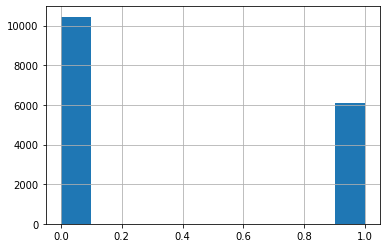

In [17]:
preds["classification_predictions"].hist()

<AxesSubplot:>

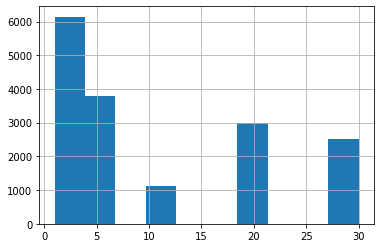

In [18]:
preds["regression_predictions"].hist()

In [19]:
# preds_classif = (pd.read_csv(f"predictions_classification.csv")["classification_predictions"].values < 3).astype(int)
# preds_regr = pd.read_csv(f"predictions_regression.csv")["regression_predictions"].values

In [20]:
!pwd

/media/paniquex/samsung_2tb/IDAO_2021_oski/notebooks


In [21]:
!ls

' analyze_predictions.ipynb'
 collab_training_pipeline_pseudolabeling-Copy1.ipynb
 collab_training_pipeline_pseudolabeling.ipynb
'Convert Samplerate.ipynb'
 csv_generate.ipynb
 debug.ipynb
 EDA.ipynb
 embeddings_generation.ipynb
 inference_pipeline_balanced.ipynb
 inference_pipeline.ipynb
 mean-teachers-find-more-birds-Copy1.ipynb
 mean-teachers-find-more-birds-Copy2.ipynb
 mean-teachers-find-more-birds-Copy3.ipynb
 mean-teachers-find-more-birds.ipynb
 predictions_joint.csv
 predictions_joint_postprocessed.csv
 predictions_threshold.csv
 sandbox
 test_predicts.ipynb
 training_pipeline_balanced-Copy1.ipynb
 training_pipeline_balanced.ipynb
 training_pipeline_finetuning.ipynb
 training_pipeline.ipynb
 vizualize_predictions.ipynb


In [22]:
os.path.join(config["general"]["out_path"], 
                          f"predictions_{config['general']['task_type']}_postprocessed_{config['general']['model_name']}.csv")

'../experiments/resnest50d_4s2x40d_1e-4_joint_BCE_L1_with_private_augmented/predictions_joint_postprocessed_resnest50d_4s2x40d.csv'